# Exercise 1
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

%matplotlib inline

In [2]:
DIGIT_SIZE_X = 28
DIGIT_SIZE_Y = 28

Utility functions used to measure the performance of the classifier:

In [3]:
from matplotlib import cm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


def measure_performance(clf, X, y):
    y_pred = clf.predict(X)
    accuracy = np.sum(y_pred == y) / y.shape[0]
    print('Accuracy: ', accuracy * 100, '%')
    conf_matrix = confusion_matrix(y, y_pred)
    conf_matrix_norm = normalize_confusion_matrix(conf_matrix)
    plot_confusion_matrix(conf_matrix_norm)


def normalize_confusion_matrix(conf_matrix):
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_norm = conf_matrix / row_sums
    np.fill_diagonal(conf_matrix_norm, 0)
    return conf_matrix_norm


def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=cm.get_cmap('viridis'))
    fig.colorbar(cax)

Loading and preparing the data:

In [4]:
mnist = fetch_mldata('MNIST original')
X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## Neural network
First we will train to obtain the best hyperparameters for the neural network using GridSearchCV:

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alpha_options = 10.0 ** -np.arange(1, 7)
solvers = ['lbfgs', 'sgd', 'adam']
hidden_layer_options = [(100,), (100, 100), (200,), (200,150), (200, 125, 50)]

param_grid = [
    {
        'alpha': alpha_options,
        'solver': solvers,
        'hidden_layer_sizes': hidden_layer_options,
    }
]

mlp_clf = MLPClassifier()
grid = GridSearchCV(mlp_clf, cv=3, param_grid=param_grid)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
grid.fit(X_train_scaled, y_train)
grid.best_params_

Now we can create a MLPClassifier using the parameters previously obtained, and we measure its performance on the test set:

/Users/alejandro/anaconda/envs/ml/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy:  97.2928571429 %


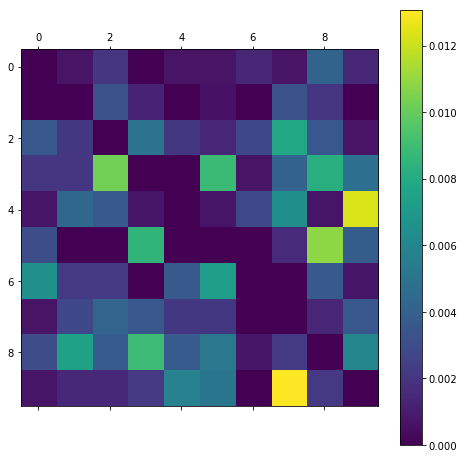

In [6]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(200,), alpha=10.0 ** -3, solver='adam')
scaler = StandardScaler()

pipeline = Pipeline([('scaler', scaler), ('neural_net', mlp_clf)])
pipeline.fit(X_train, y_train)

measure_performance(pipeline, X_test, y_test)

The accuracy is over 97%. As we can see, most errors come from confusing twos, sevens, and eights with the digit 3. However, the digit 3 itself is not confused with other digits so much. 

# Exercise 2
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set.

In [7]:
from scipy.ndimage.interpolation import shift


def shift_digits(X, y):
    shifted_digits = list()

    for index, digit in enumerate(X):
        digit = np.reshape(digit, (DIGIT_SIZE_X, DIGIT_SIZE_Y))
        shifted_digits.append(shift(digit, (-1,  0)))     # left
        shifted_digits.append(shift(digit, ( 1,  0)))     # right
        shifted_digits.append(shift(digit, ( 0,  1)))     # up
        shifted_digits.append(shift(digit, ( 0, -1)))     # down
        new_y = [y[index] for i in range(4)]
        y = np.concatenate((y, new_y))

    shifted_digits = [np.reshape(digit, (DIGIT_SIZE_X * DIGIT_SIZE_Y,))
                      for digit in shifted_digits]
    return np.concatenate((X, shifted_digits)), y


X_train, y_train = shift_digits(X_train, y_train)

Accuracy:  98.1785714286 %


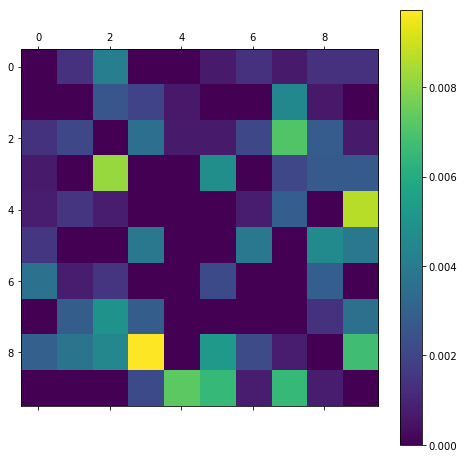

In [8]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(200,), alpha=10.0 ** -3, solver='adam')
scaler = StandardScaler()

pipeline = Pipeline([('scaler', scaler), ('neural_net', mlp_clf)])
pipeline.fit(X_train, y_train)

measure_performance(pipeline, X_test, y_test)

After adding the shifted images to the train set, the accuracy of the classifier increased to 98.17%